In [30]:
!git clone https://github.com/pdhruv93/Face-Recognition-OpenCV-Caffe.git

Cloning into 'Face-Recognition-OpenCV-Caffe'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 68 (delta 4), reused 65 (delta 4), pack-reused 0
Unpacking objects: 100% (68/68), done.


In [31]:
%cd Face-Recognition-OpenCV-Caffe//opencv-face-recognition-caffe//

/content/Face-Recognition-OpenCV-Caffe/opencv-face-recognition-caffe/Face-Recognition-OpenCV-Caffe/opencv-face-recognition-caffe/Face-Recognition-OpenCV-Caffe/opencv-face-recognition-caffe


In [0]:
from imutils import paths
import numpy as np
import imutils
import pickle
import cv2
import os

In [0]:
datasetPath="dataset/"  #path to our input images which we will embed
face_detector_model_Path="face_detection_model//"   #path to Caffe face detector to localize faces in an image
face_embedding_model_Path="face_embedding_model//"  #This model is Torch-based and is responsible for extracting facial embeddings via deep learning feature extraction
myFaceEmbeddingsPath="myFaceEmbeddings.pickle" #our output file which will store face embeddings of input image   

#command line arguments in dict form
#dataset-- path to our dataset(input images)
#detector--path to OpenCV's deep learning face detector model(Caffe). this will detect faces from input images
#embeddings -- path to face embedder model
#confidence -- Optional threshold for filtering week face detections
args={'dataset': datasetPath , 'face_detector_model': face_detector_model_Path ,'face_embedding_model': face_embedding_model_Path , 'myFaceEmbeddings': myFaceEmbeddingsPath, 'confidence': 0.3 }

In [34]:
# load our face detector model(Caffe) from disk
print("[INFO] loading face detector...")
protoPath = args["face_detector_model"] + "deploy.prototxt"
modelPath = args["face_detector_model"] + "res10_300x300_ssd_iter_140000.caffemodel"
detector = cv2.dnn.readNetFromCaffe(protoPath, modelPath)
 
# load our face embedding model from disk
print("[INFO] loading face embedder...")
embedder = cv2.dnn.readNetFromTorch(args["face_embedding_model"] + "openface_nn4.small2.v1.t7")

[INFO] loading face detector...
[INFO] loading face embedder...


In [35]:
# grab the paths to the input images in our dataset
print("[INFO] quantifying faces...")
imagePaths = list(paths.list_images(args["dataset"]))
print(imagePaths)
 
# These two lists will contain the face encodings and corresponding names for each person in the dataset(currently only 1 person)
knownEncodings = []
knownNames = []

[INFO] quantifying faces...
['dataset/unknown/claire_dearing.jpg', 'dataset/unknown/ian_malcolm.jpg', 'dataset/unknown/ellie_sattler.jpg', 'dataset/unknown/alan_grant.jpg', 'dataset/unknown/john_hammond.jpg', 'dataset/unknown/own_grady.jpg', 'dataset/dhruv/IMG_20180605_211515.jpg', 'dataset/dhruv/IMG_20180404_234725.jpg', 'dataset/dhruv/IMG_20181203_132032.jpg', 'dataset/dhruv/IMG_20180520_184209.jpg', 'dataset/dhruv/IMG_20180520_184234.jpg', 'dataset/dhruv/IMG_20180601_153933.jpg', 'dataset/dhruv/IMG_3760.JPG', 'dataset/dhruv/IMG_20180605_211540.jpg', 'dataset/dhruv/IMG_4887.JPG', 'dataset/dhruv/IMG-20180903-WA0129.jpg', 'dataset/dhruv/IMG_20180929_170034.jpg', 'dataset/dhruv/IMG_20180520_184325.jpg', 'dataset/dhruv/IMG-20180903-WA0121.jpg', 'dataset/dhruv/IMG_5248.JPG', 'dataset/dhruv/IMG_20180410_135431.jpg', 'dataset/dhruv/IMG_20180408_131938.jpg', 'dataset/dhruv/IMG_20180526_095231.jpg', 'dataset/dhruv/IMG_20180608_233825.jpg', 'dataset/dhruv/IMG_5249.JPG', 'dataset/dhruv/IMG_5075

In [36]:
# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
  print("[INFO] processing image {}/{}".format(i + 1,len(imagePaths)))
  
  # extract the person name from the image path
  # dataset//dhruv//IMG_20180605_211534.jpg.. 0 is dataset 1 is dhruv
  name = imagePath.split("/")[1]
  
  # load the input image
  image = cv2.imread(imagePath)
  image = imutils.resize(image, width=600)
  #print(image.shape) -- (800,600,3)
  (h, w) = image.shape[:2] #extract 0-1 means 800,600
  
  # construct a blob from the image
  imageBlob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300),(104.0, 177.0, 123.0), swapRB=False, crop=False)
  #mageBlob = cv2.dnn.blobFromImage(image, swapRB=False, crop=False)
  
  # apply Caffe face detector to localize faces in the input image
  detector.setInput(imageBlob)
  detections = detector.forward()
  
  
  if len(detections) > 0:     # ensure at least one face was found
    # we're making the assumption that each image has only ONE face, so find the bounding box with the largest probability
    i = np.argmax(detections[0, 0, :, 2])  #difficult to understand this
    
    #get confidence for index with largest probability
    confidence = detections[0, 0, i, 2]
 
		#ensure that the 1 detection with the largest probability also has confidence greater then minimum confidence
    if confidence > args["confidence"]:
			# compute the (x, y)-coordinates of the bounding box for the face
      box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])  #difficult to understand this
      (startX, startY, endX, endY) = box.astype("int")
 
			# extract the face ROI and grab the ROI dimensions
      face = image[startY:endY, startX:endX]
      (fH, fW) = face.shape[:2]
      
			# ensure the face width and height are sufficiently large
      if fW < 20 or fH < 20:
        print("[INFO] small face. IGNORING!")
        continue
      else:
        pass
        #cv2.rectangle(image, (startX, startY), (endX, endY),(0, 0, 255), 2)
        #plt.imshow(image,shape=(50,50))
        #plt.show()
      
      # construct a blob for the face ROI, then pass the blob through our face embedding model to obtain the 128-d quantification of the face
      faceBlob = cv2.dnn.blobFromImage(face, 1.0 / 255, (96, 96), (0, 0, 0), swapRB=True, crop=False)
      
      embedder.setInput(faceBlob)
      vec = embedder.forward()
 
			# add the name of the person + corresponding face embedding to their respective lists
      knownNames.append(name)
      knownEncodings.append(vec.flatten())

[INFO] processing image 1/38
[INFO] processing image 2/38
[INFO] processing image 3/38
[INFO] processing image 4/38
[INFO] processing image 5/38
[INFO] processing image 6/38
[INFO] processing image 7/38
[INFO] processing image 8/38
[INFO] processing image 9/38
[INFO] processing image 10/38
[INFO] processing image 11/38
[INFO] processing image 12/38
[INFO] processing image 13/38
[INFO] processing image 14/38
[INFO] processing image 15/38
[INFO] processing image 16/38
[INFO] processing image 17/38
[INFO] processing image 18/38
[INFO] processing image 19/38
[INFO] processing image 20/38
[INFO] processing image 21/38
[INFO] processing image 22/38
[INFO] processing image 23/38
[INFO] processing image 24/38
[INFO] processing image 25/38
[INFO] processing image 26/38
[INFO] processing image 27/38
[INFO] processing image 28/38
[INFO] processing image 29/38
[INFO] processing image 30/38
[INFO] processing image 31/38
[INFO] processing image 32/38
[INFO] processing image 33/38
[INFO] processing i

In [37]:
print(len(knownNames))

38


In [38]:
!ls
!rm args["myFaceEmbeddingsPath"]

dataset  face_detection_model  face_embedding_model  images
rm: cannot remove 'args[myFaceEmbeddingsPath]': No such file or directory


In [39]:
# dump the facial embeddings + names to disk
print("[INFO] serializing encodings...")
data = {"embeddings": knownEncodings, "names": knownNames}
f = open(args["myFaceEmbeddings"], "wb")
f.write(pickle.dumps(data))
f.close()
#TILL NOW WE HAVE FOUND THE ENCODINGS OF FACES IN INPUT DATSET

[INFO] serializing encodings...


In [40]:
!ls

dataset		      face_embedding_model  myFaceEmbeddings.pickle
face_detection_model  images


**Step1: At this point we have extracted 128-d embeddings for each face  --Done**

**Step2: We will now create a ML model(such as an SVM, k-NN classifier, Random Forest, etc.) and train it on our embeddings that we generated**

**Step3: We use this model to recognise face in our input image**

In [0]:
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
import argparse
import pickle
from matplotlib import pyplot as plt

In [0]:
myFaceEmbeddingsPath="myFaceEmbeddings.pickle" #our input file where we stopred face embeddings of input images
face_recognizer_model_Path="my_face_recognizer.pickle"   #our output model for face recognition that we have trained
encoded_Labels_Path="encoded_labels.pickle" #path to label encoder

#command line arguments in dict form
args={'inputFaceEmbeddings': myFaceEmbeddingsPath , 'faceRecognizerModel': face_recognizer_model_Path ,'encoded_labels': encoded_Labels_Path }

In [43]:
# load the face embeddings
print("[INFO] loading face embeddings...")
data = pickle.loads(open(args["inputFaceEmbeddings"], "rb").read())
 
# encode the labels
#why to encode lables: https://medium.com/@contactsunny/label-encoder-vs-one-hot-encoder-in-machine-learning-3fc273365621
print("Original Label:: {}".format(data["names"][0]))
print("[INFO] encoding labels...")
le = LabelEncoder()  #initialize our scikit-learn LabelEncoder
labels = le.fit_transform(data["names"])
print("Encoded Label:: {}".format(labels[0]))

[INFO] loading face embeddings...
Original Label:: unknown
[INFO] encoding labels...
Encoded Label:: 1


In [44]:
print("[INFO] training model...")
#initialize our SVM model.
#here a Linear Support Vector Machine (SVM) model has been used but other machine learning models can also be used
recognizer = SVC(C=1.0, kernel="linear", probability=True)   
recognizer.fit(data["embeddings"], labels)   #fit  the model (also known as “training the model”)...model.fit(x,y)

[INFO] training model...


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [45]:
!rm args["faceRecognizerModel"]
!rm args["encoded_labels"]

rm: cannot remove 'args[faceRecognizerModel]': No such file or directory
rm: cannot remove 'args[encoded_labels]': No such file or directory


In [0]:
#We write two pickle files to disk in this block — the face recognizer model and the label encoder.

# write the actual face recognition model to disk
f = open(args["faceRecognizerModel"], "wb")
f.write(pickle.dumps(recognizer))
f.close()
 
# write the label encoder to disk
f = open(args["encoded_labels"], "wb")
f.write(pickle.dumps(le))
f.close()

In [47]:
!ls

dataset		       face_embedding_model	my_face_recognizer.pickle
encoded_labels.pickle  images
face_detection_model   myFaceEmbeddings.pickle


**Step1: At this point we have extracted 128-d embeddings for each face  --Done**

**Step2: We will now create a ML model(such as an SVM, k-NN classifier, Random Forest, etc.) and train it on our embeddings that we generated --Done**

**Step3: We use this model to recognise face in our input image**

In [0]:
inputImagePath="images//IMG-20181003-WA0025.jpg" #image-- path to our image on which we will detect face
face_detector_model_Path="face_detection_model//"   #path to Caffe face detector to localize faces in an image
face_embedding_model_Path="face_embedding_model//"  #This model is Torch-based and is responsible for extracting facial embeddings via deep learning feature extraction
face_recognizer_Path="my_face_recognizer.pickle"  #our recognizer model that we trained in Step2
encoded_lables_Path="encoded_labels.pickle"  #our encoded lables generated in Step2  

#command line arguments in dict form
#dataset-- path to our dataset(input images)
#detector--path to OpenCV's deep learning face detector model(Caffe). this will detect faces from input images
#embeddings -- path to face embedder model
#confidence -- Optional threshold for filtering week face detections
args={'image': inputImagePath , 'face_detector_model': face_detector_model_Path ,'face_embedding_model': face_embedding_model_Path , 'face_recognizing_model': face_recognizer_Path, 'encoded_lables': encoded_lables_Path, 'confidence': 0.3, 'minMatchProbability': 0.9 }

In [49]:
# load our serialized face detector from disk
print("[INFO] loading face detector...")
protoPath = args["face_detector_model"] + "deploy.prototxt"
modelPath = args["face_detector_model"] + "res10_300x300_ssd_iter_140000.caffemodel"
detector = cv2.dnn.readNetFromCaffe(protoPath, modelPath)
 
# load our face embedding model from disk
print("[INFO] loading face embedder...")
embedder = cv2.dnn.readNetFromTorch(args["face_embedding_model"] + "openface_nn4.small2.v1.t7")
 
# load the actual face recognition model along with the label encoder
recognizer = pickle.loads(open(args["face_recognizing_model"], "rb").read())
le = pickle.loads(open(args["encoded_lables"], "rb").read())

[INFO] loading face detector...
[INFO] loading face embedder...


In [0]:
# load the image, resize it to have a width of 600 pixels
image = cv2.imread(args["image"])
image = imutils.resize(image, width=600)
(h, w) = image.shape[:2]

# construct a blob from the image
imageBlob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300),(104.0, 177.0, 123.0), swapRB=False, crop=False)
#imageBlob = cv2.dnn.blobFromImage(image, swapRB=False, crop=False)
 
# apply OpenCV's deep learning-based face detector to localize faces in the input image
detector.setInput(imageBlob)
detections = detector.forward()

In [53]:
# loop over the detections
for i in range(0, detections.shape[2]):
	# extract the confidence (i.e., probability) associated with the prediction
	confidence = detections[0, 0, i, 2]
 
	# filter out weak detections
	if confidence > args["confidence"]:
		# compute the (x, y)-coordinates of the bounding box for the face
		box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		(startX, startY, endX, endY) = box.astype("int")
 
		# extract the face ROI
		face = image[startY:endY, startX:endX]
		(fH, fW) = face.shape[:2]
    
		# ensure the face width and height are sufficiently large
		if fW < 20 or fH < 20:
			print("[INFO] small face. IGNORING!")
			continue
		else:
			pass
			#cv2.rectangle(image, (startX, startY), (endX, endY),(0, 0, 255), 2)
			#plt.imshow(image,shape=(50,50))
			#plt.show()
      
		# construct a blob for the face ROI, 
		faceBlob = cv2.dnn.blobFromImage(face, 1.0 / 255, (96, 96),(0, 0, 0), swapRB=True, crop=False)
		#faceBlob = cv2.dnn.blobFromImage(face, 1.0 / 255, swapRB=True, crop=False)
    
		# then pass the blob through our face embedding model to obtain the 128-d quantification of the face
		embedder.setInput(faceBlob)
		vec = embedder.forward()
 
		# we pass the vec  through our SVM recognizer model, the result of which is our predictions for who is in the face ROI.
		preds = recognizer.predict_proba(vec)[0]
    
		#We take the highest probability index
		j = np.argmax(preds)
		proba = preds[j]
		print("Detected a face with probability: {}".format(proba * 100))
    
		if proba < args["minMatchProbability"]:
			continue
    
		#get the decoded label(name of the person)
		name = le.classes_[j]
    
		# draw the bounding box of the face along with the associated probability
		text = "{}: {:.2f}%".format(name, proba * 100)
		y = startY - 10 if startY - 10 > 10 else startY + 10
		cv2.rectangle(image, (startX, startY), (endX, endY),(0, 0, 255), 2)
		cv2.putText(image, text, (startX, y),cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

Detected a face with probability: 83.79689567629516
Detected a face with probability: 92.5855046349592


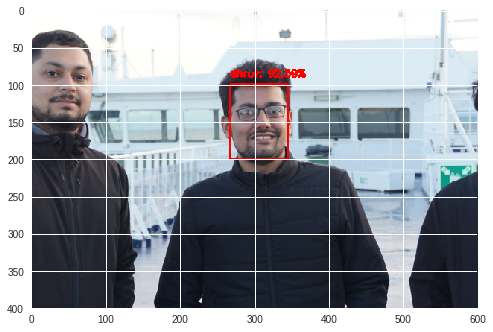

In [54]:
# show the output image
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image,shape=(50,50))
plt.show()